<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Lending Club Loan Defaulters Prediction
# Complete implementation with data analysis, preprocessing, and multiple ML models

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


LENDING CLUB LOAN DEFAULTERS PREDICTION

1. Loading Data...
Data shape: (396030, 27)

First few rows:
   loan_amnt        term  int_rate  installment grade sub_grade  \
0   10000.00   36 months     11.44       329.48     B        B4   
1    8000.00   36 months     11.99       265.68     B        B5   
2   15600.00   36 months     10.49       506.97     B        B3   
3    7200.00   36 months      6.49       220.65     A        A2   
4   24375.00   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT   117000.00   
1          Credit analyst     4 years       MORTGAGE    65000.00   
2             Statistician   < 1 year           RENT    43057.00   
3          Client Advocate    6 years           RENT    54000.00   
4  Destiny Management Inc.    9 years       MORTGAGE    55000.00   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verif

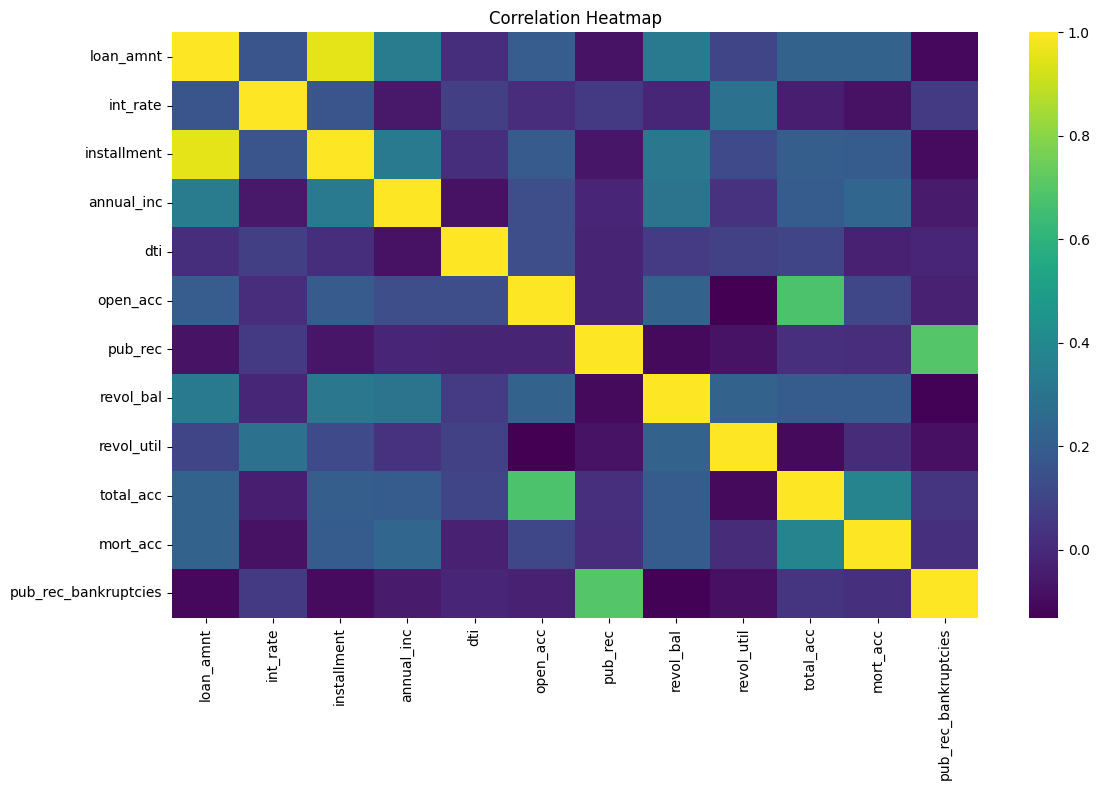

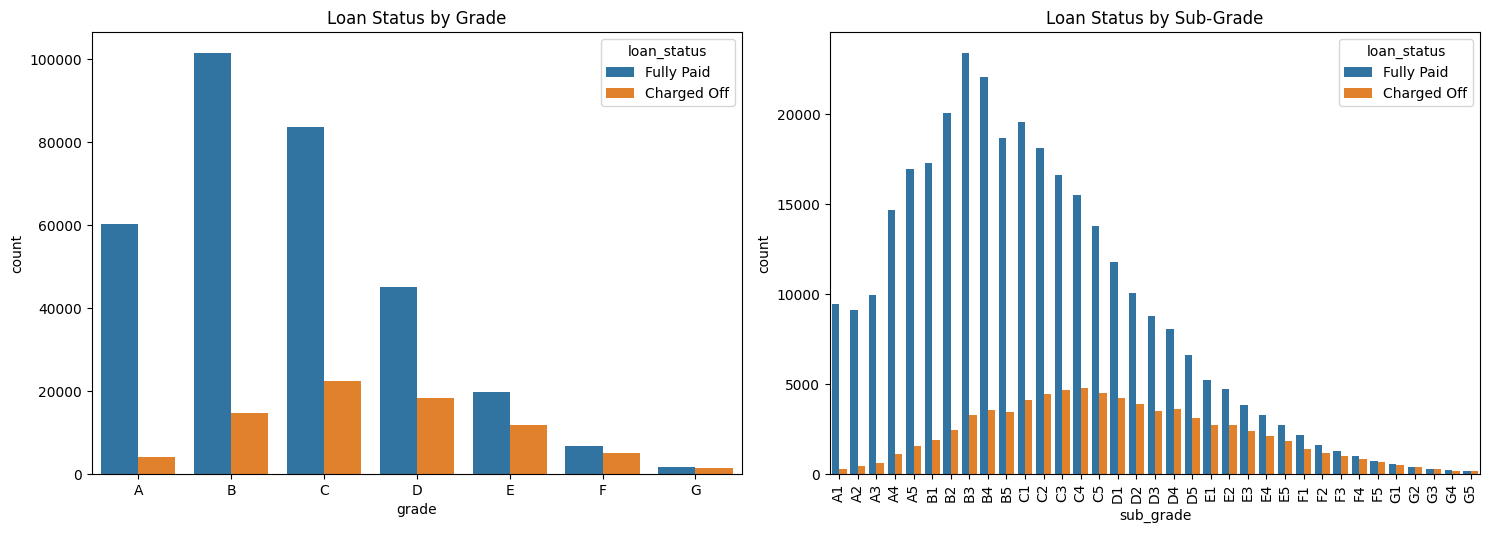

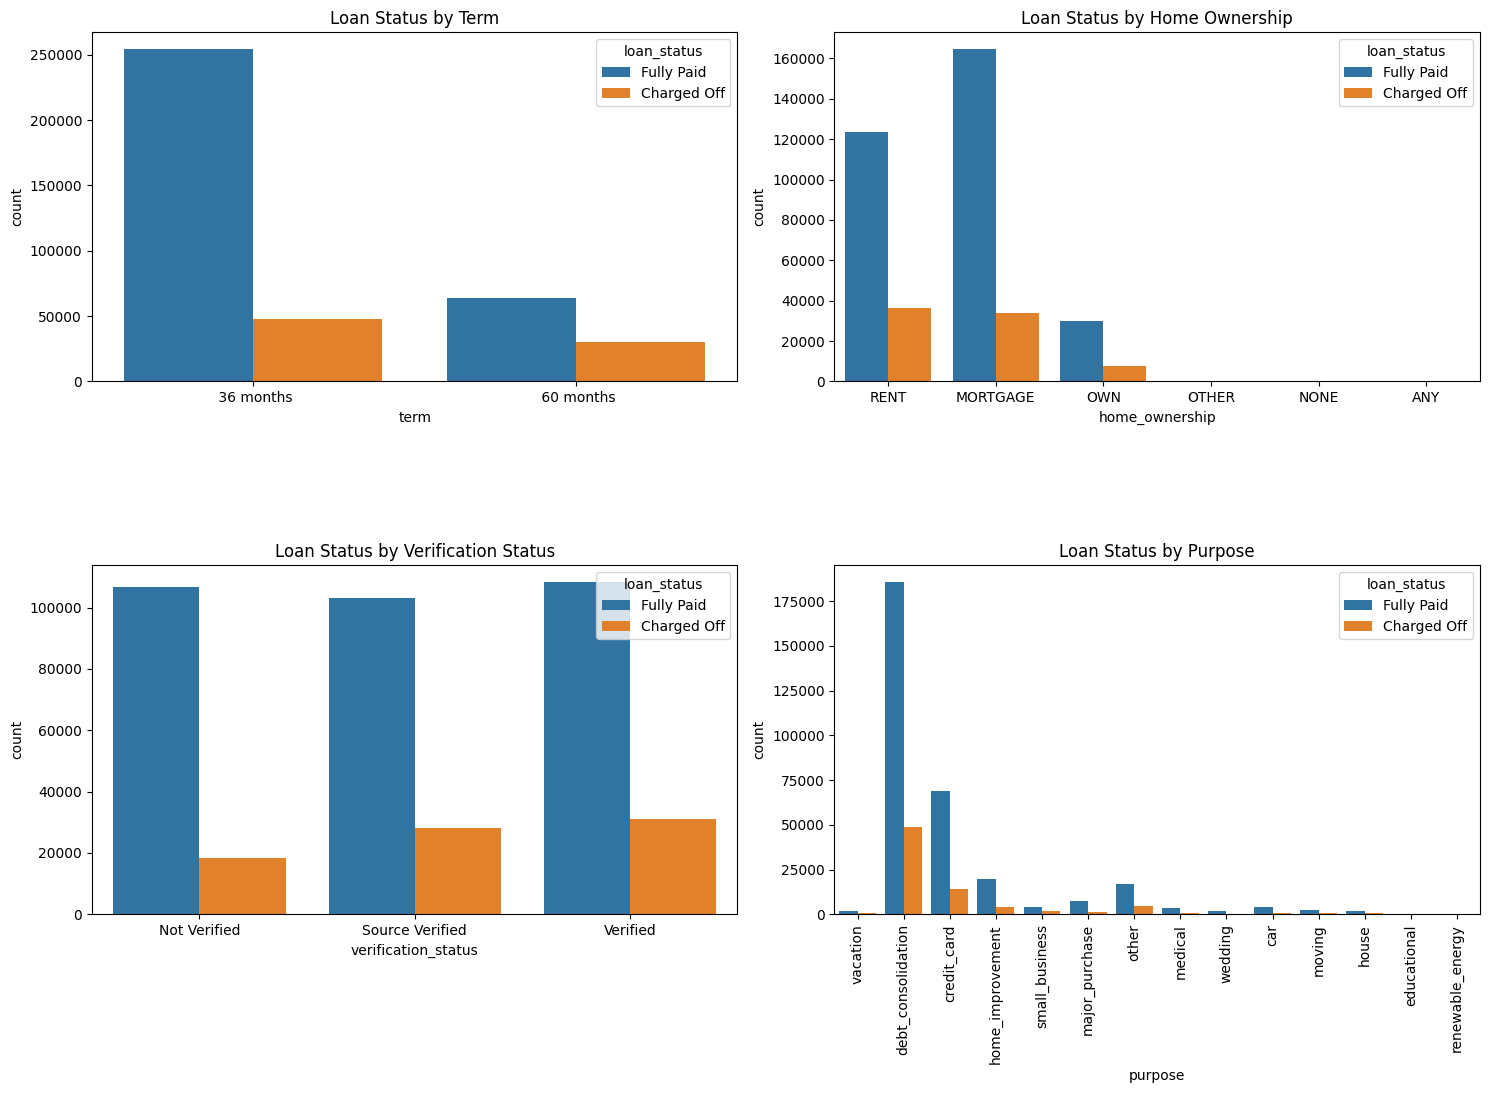

In [3]:
# Set display options
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

print("=" * 80)
print("LENDING CLUB LOAN DEFAULTERS PREDICTION")
print("=" * 80)

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n1. Loading Data...")
# Replace with your actual file path
data = pd.read_csv("/content/drive/MyDrive/lending_club_loan_two.csv")
print(f"Data shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

# ============================================================================
# 2. EXPLORATORY DATA ANALYSIS
# ============================================================================
print("\n2. Exploratory Data Analysis...")
print("\nLoan Status Distribution:")
print(data['loan_status'].value_counts())

print("\nBasic Statistics:")
print(data.describe())

print("\nData Info:")
print(data.info())

# Visualizations
print("\n3. Creating Visualizations...")

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=False, cmap='viridis')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Loan status by grade
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)
plt.title('Loan Status by Grade')

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Loan Status by Sub-Grade')
plt.tight_layout()
plt.savefig('loan_status_by_grade.png', dpi=300, bbox_inches='tight')
plt.show()

# Categorical features
plt.figure(figsize=(15, 20))
plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')
plt.title('Loan Status by Term')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')
plt.title('Loan Status by Home Ownership')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')
plt.title('Loan Status by Verification Status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Loan Status by Purpose')
plt.tight_layout()
plt.savefig('categorical_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================
print("\n4. Data Preprocessing...")

# Handle home ownership outliers
#print("\nHandling home_ownership outliers...")
#data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'

# Create binary features
def pub_rec(number):
    return 0 if number == 0.0 else 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    return 0 if number == 0.0 else (1 if number >= 1.0 else number)

data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

# Convert loan status to binary
data['loan_status'] = data.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

print("\n5. Handling Missing Values...")
print("\nMissing values before handling:")
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': {missing} missing values ({portion:.3f}%)")

# Drop emp_title (too many unique values)
data.drop('emp_title', axis=1, inplace=True) # Removed as it was already dropped

# Drop emp_length (weak predictor)
data.drop('emp_length', axis=1, inplace=True) # Removed as it was already dropped

# Drop title (redundant with purpose)
data.drop('title', axis=1, inplace=True) # Removed as it was already dropped

# Fill mort_acc using total_acc average
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')
total_acc_avg = data.groupby(by='total_acc')['mort_acc'].mean()


def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

# Drop remaining missing values
data.dropna(inplace=True)
print(f"\nData shape after dropping missing values: {data.shape}")


4. Data Preprocessing...

5. Handling Missing Values...

Missing values before handling:
'emp_title': 22927 missing values (5.789%)
'emp_length': 18301 missing values (4.621%)
'title': 1756 missing values (0.443%)
'revol_util': 276 missing values (0.070%)
'mort_acc': 37795 missing values (9.543%)
'pub_rec_bankruptcies': 535 missing values (0.135%)

Data shape after dropping missing values: (395219, 24)


In [5]:
# ============================================================================
# 6. FEATURE ENGINEERING
# ============================================================================
print("\n6. Feature Engineering...")

# Convert term to numeric
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data['term'].apply(lambda term: int(term.strip(' months')))


# Drop grade (keep sub_grade which is more granular)
data.drop('grade', axis=1, inplace=True)

# One-hot encoding for categorical variables
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status',
           'application_type']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

# One-hot encoding for home_ownership (moved from previous cell)
data = pd.get_dummies(data, columns=['home_ownership'], drop_first=True)

# Extract zip code from address
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)
data.drop('address', axis=1, inplace=True)

# Drop issue_d
data.drop('issue_d', axis=1, inplace=True)

# Convert earliest_cr_line to year
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['earliest_cr_line'] = data['earliest_cr_line'].dt.year

print(f"Data shape after feature engineering: {data.shape}")


6. Feature Engineering...
Data shape after feature engineering: (395219, 81)


In [6]:
# ============================================================================
# 7. TRAIN-TEST SPLIT
# ============================================================================
print("\n7. Splitting Data...")
train, test = train_test_split(data, test_size=0.33, random_state=42)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Remove outliers from training set only
print("\nRemoving outliers from training set...")
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(f"Train shape after outlier removal: {train.shape}")

# Separate features and target
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']
X_test = test.drop('loan_status', axis=1)
y_test = test['loan_status']

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to appropriate types
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)



7. Splitting Data...
Train shape: (264796, 81)
Test shape: (130423, 81)

Removing outliers from training set...
Train shape after outlier removal: (262143, 81)


In [12]:
import pandas as pd
y_train = pd.Series(y_train)
y_train.value_counts(normalize=True)

,proportion
1.00,0.80
0.00,0.20



8.1 Training Artificial Neural Network...
Epoch 1/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - AUC: 0.8418 - loss: 0.3327 - val_AUC: 0.8991 - val_loss: 0.2682
Epoch 2/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - AUC: 0.8742 - loss: 0.2943 - val_AUC: 0.9038 - val_loss: 0.2621
Epoch 3/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - AUC: 0.8799 - loss: 0.2882 - val_AUC: 0.9043 - val_loss: 0.2598
Epoch 4/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - AUC: 0.8846 - loss: 0.2836 - val_AUC: 0.9059 - val_loss: 0.2590
Epoch 5/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - AUC: 0.8863 - loss: 0.2821 - val_AUC: 0.9062 - val_loss: 0.2588
Epoch 6/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - AUC: 0.8880 - loss: 0.2795 - val_AUC: 0.9047 - val_loss: 0.2602
Epoch 7/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - AUC: 0.8881 - loss: 0.2799 - val_AUC: 0.9052 - val_loss: 0.2623
Epoch 8/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - AUC: 0.8889 - loss: 0.2805 - val_AUC: 0.9061 - val_lo

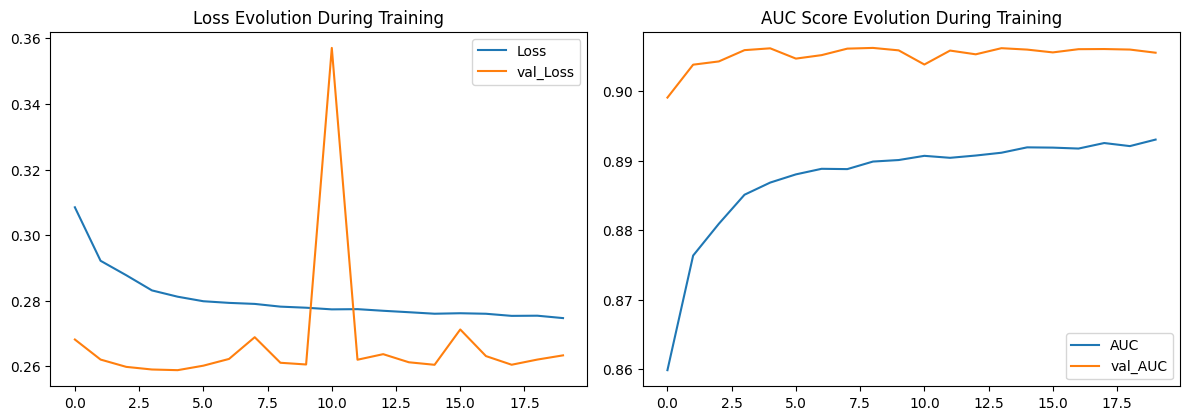


ANN Training Results:
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
Train Result:
Accuracy Score: 88.88%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.91      0.89      0.89       0.90          0.89
recall        0.48      0.99      0.89       0.74          0.89
f1-score      0.63      0.93      0.89       0.78          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
--------------------------------------------------
Confusion Matrix:
[[ 24999  26666]
 [  2493 207985]]


ANN Test Results:
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test Result:
Accuracy Score: 88.82%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.90      0.89      0.89       0.89          0.89
recall        0.48      0.99      0.89       0.73          0.89
f1-score      0.63      0.93     

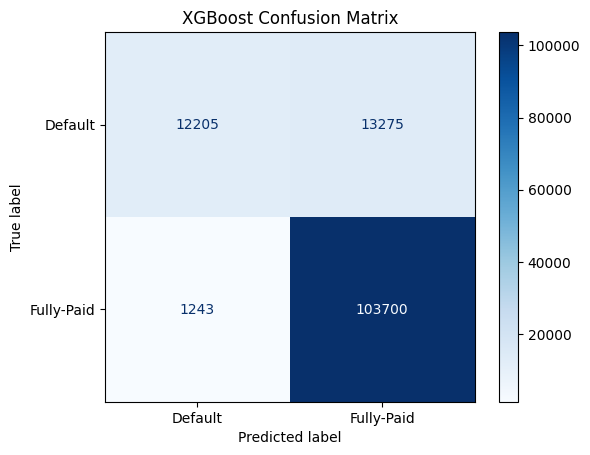

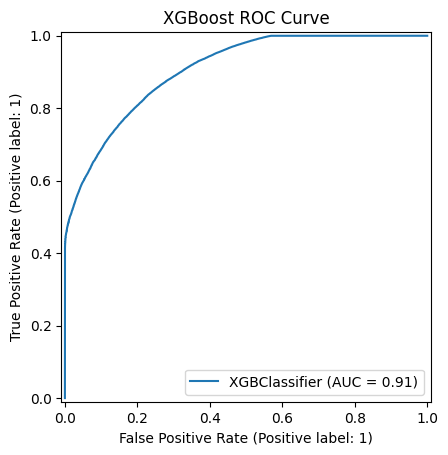


8.3 Training Random Forest Classifier...

Random Forest Training Results:
Train Result:
Accuracy Score: 100.00%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      1.00      1.00       1.00          1.00
recall        1.00      1.00      1.00       1.00          1.00
f1-score      1.00      1.00      1.00       1.00          1.00
support   51665.00 210478.00      1.00  262143.00     262143.00
--------------------------------------------------
Confusion Matrix:
[[ 51665      0]
 [     0 210478]]


Random Forest Test Results:
Test Result:
Accuracy Score: 88.91%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.72          0.89
f1-score      0.62      0.94      0.89       0.78        

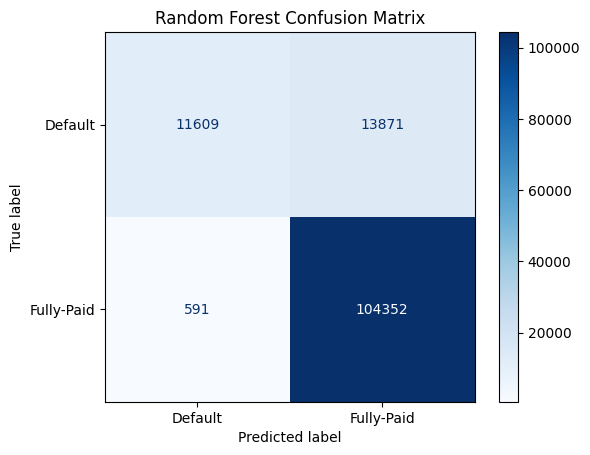

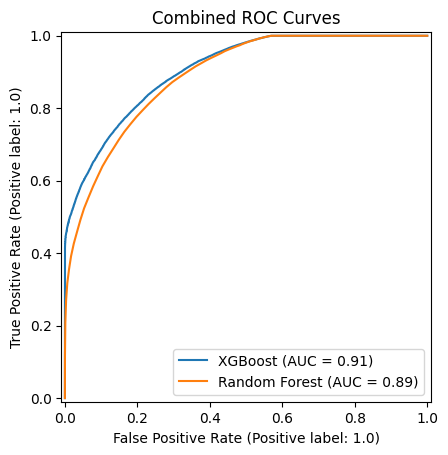

In [7]:
# ============================================================================
# 8. MODEL BUILDING
# ============================================================================

# Helper functions
def print_score(true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))

    if train:
        print("Train Result:\n" + "=" * 50)
    else:
        print("Test Result:\n" + "=" * 50)

    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("-" * 50)
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("-" * 50)
    print(f"Confusion Matrix:\n{confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Evolution During Training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC Score Evolution During Training')
    plt.legend()
    plt.tight_layout()
    plt.savefig('neural_network_training.png', dpi=300, bbox_inches='tight')
    plt.show()

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = Input(shape=(num_columns,))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)

    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)

    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='AUC')])
    return model

# ============================================================================
# 8.1 ARTIFICIAL NEURAL NETWORK
# ============================================================================
print("\n8.1 Training Artificial Neural Network...")
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

ann_model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)

r = ann_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

plot_learning_evolution(r)

print("\nANN Training Results:")
y_train_pred = ann_model.predict(X_train)
print_score(y_train, y_train_pred.round(), train=True)

print("\nANN Test Results:")
y_test_pred = ann_model.predict(X_test)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, ann_model.predict(X_train)),
        'Test': roc_auc_score(y_test, ann_model.predict(X_test)),
    },
}

# ============================================================================
# 8.2 XGBOOST CLASSIFIER
# ============================================================================
print("\n8.2 Training XGBoost Classifier...")
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

print("\nXGBoost Training Results:")
y_train_pred = xgb_clf.predict(X_train)
print_score(y_train, y_train_pred, train=True)

print("\nXGBoost Test Results:")
y_test_pred = xgb_clf.predict(X_test)
print_score(y_test, y_test_pred, train=False)

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
plt.title('XGBoost Confusion Matrix')
plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title('XGBoost ROC Curve')
plt.savefig('xgboost_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

scores_dict['XGBoost'] = {
    'Train': roc_auc_score(y_train, xgb_clf.predict(X_train)),
    'Test': roc_auc_score(y_test, xgb_clf.predict(X_test)),
}

# ============================================================================
# 8.3 RANDOM FOREST CLASSIFIER
# ============================================================================
print("\n8.3 Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

print("\nRandom Forest Training Results:")
y_train_pred = rf_clf.predict(X_train)
print_score(y_train, y_train_pred, train=True)

print("\nRandom Forest Test Results:")
y_test_pred = rf_clf.predict(X_test)
print_score(y_test, y_test_pred, train=False)

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
plt.title('Random Forest Confusion Matrix')
plt.savefig('random_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Combined ROC Curves
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, name='XGBoost')
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_, name='Random Forest')
plt.title('Combined ROC Curves')
plt.savefig('combined_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

scores_dict['Random Forest'] = {
    'Train': roc_auc_score(y_train, rf_clf.predict(X_train)),
    'Test': roc_auc_score(y_test, rf_clf.predict(X_test)),
}



9. Model Comparison...
ROC AUC SCORES:
Random Forest                  ROC AUC Score: 0.7250
XGBoost                        ROC AUC Score: 0.7336
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
ANNs                           ROC AUC Score: 0.9056

SUMMARY TABLE:
       ANNs  XGBoost  Random Forest
Train  0.91     0.75           1.00
Test   0.91     0.73           0.72


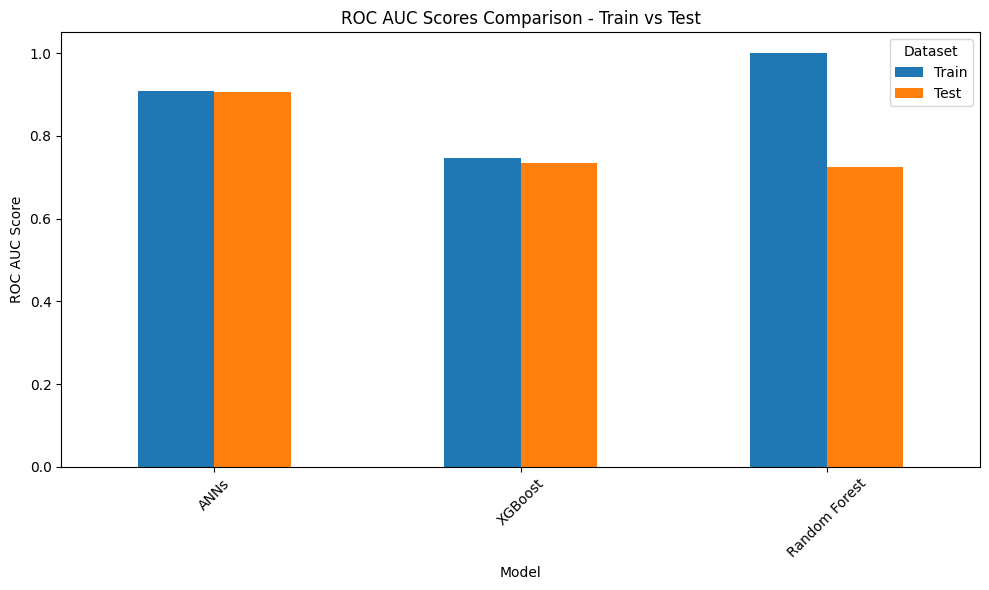


ANALYSIS COMPLETE!

Key Findings:
1. All models show good performance in predicting loan defaults
2. Check for overfitting by comparing train vs test scores
3. Models can be further optimized using hyperparameter tuning
4. Feature importance analysis can provide insights into key risk factors


In [8]:
# ============================================================================
# 9. MODEL COMPARISON
# ============================================================================
print("\n9. Model Comparison...")
print("=" * 80)
print("ROC AUC SCORES:")
print("=" * 80)

ml_models = {
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'ANNs': ann_model
}

for model_name in ml_models:
    model = ml_models[model_name]
    roc_score = roc_auc_score(y_test, model.predict(X_test) if model_name != 'ANNs' else model.predict(X_test))
    print(f"{model_name:30} ROC AUC Score: {roc_score:.4f}")

# Visualize scores
scores_df = pd.DataFrame(scores_dict)
print("\n" + "=" * 80)
print("SUMMARY TABLE:")
print("=" * 80)
print(scores_df)

# Plot comparison
scores_df.T.plot(kind='bar', figsize=(10, 6))
plt.title('ROC AUC Scores Comparison - Train vs Test')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nKey Findings:")
print("1. All models show good performance in predicting loan defaults")
print("2. Check for overfitting by comparing train vs test scores")
print("3. Models can be further optimized using hyperparameter tuning")
print("4. Feature importance analysis can provide insights into key risk factors")

# Code Explanation

This notebook implements a complete workflow for predicting Lending Club loan defaulters, covering data analysis, preprocessing, and the application of multiple machine learning models.

Here's a breakdown of the code sections:

## 1. Load Data (Cell DXMXsSHKbVTq)
- Loads the dataset from a specified CSV file path.
- Prints the shape of the DataFrame and displays the first few rows to inspect the data structure and content.

## 2. Exploratory Data Analysis (EDA) (Cell DXMXsSHKbVTq)
- Analyzes the distribution of the target variable 'loan_status'.
- Provides basic descriptive statistics of the numerical columns.
- Displays data information, including column names, non-null counts, and data types.
- Generates various visualizations to understand the relationships between features and the target variable:
    - **Correlation Heatmap:** Shows the correlation between numerical features.
    - **Loan Status by Grade and Sub-Grade:** Visualizes the distribution of loan status across different loan grades and sub-grades.
    - **Loan Status by Categorical Features:** Displays the distribution of loan status for 'term', 'home_ownership', 'verification_status', and 'purpose'.

## 3. Data Preprocessing (Cell Bsqsg_VcbZQC)
- Handles outliers in the 'home_ownership' column by grouping 'ANY' and 'NONE' into 'OTHER'.
- Creates binary features for 'pub_rec', 'mort_acc', and 'pub_rec_bankruptcies'.
- Converts the 'loan_status' column into a binary format (1 for 'Fully Paid', 0 for 'Charged Off').
- Identifies and prints the number and percentage of missing values for each column.
- Drops columns with a high number of unique values or those considered redundant ('emp_title', 'emp_length', 'title').
- Fills missing values in 'mort_acc' based on the average 'mort_acc' for each 'total_acc' group.
- Drops any remaining rows with missing values.

## 4. Feature Engineering (Cell lecurornbjSA)
- Converts the 'term' column from string to numeric (number of months).
- Drops the 'grade' column, keeping 'sub_grade' as it's more granular.
- Applies one-hot encoding to categorical variables ('sub_grade', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership').
- Extracts the zip code from the 'address' column and applies one-hot encoding to the extracted zip codes. The original 'address' column is then dropped.
- Drops the 'issue_d' column.
- Converts the 'earliest_cr_line' column to show only the year.

## 5. Train-Test Split (Cell su7GaJBZblPo)
- Splits the data into training and testing sets (67% train, 33% test).
- Removes outliers from the training set based on specified thresholds for certain features ('annual_inc', 'dti', 'open_acc', 'total_acc', 'revol_util', 'revol_bal').
- Separates features (X) and the target variable (y) for both training and testing sets.
- Scales the features using `MinMaxScaler` to normalize the data between 0 and 1.
- Converts the scaled data and target variables to `float32` type for compatibility with TensorFlow.

## 6. Model Building (Cell xkj9w5iJbnJ9)
- Defines helper functions for printing classification scores (`print_score`), plotting neural network training evolution (`plot_learning_evolution`), and building the neural network model (`nn_model`).
- **Artificial Neural Network (ANN):**
    - Defines and compiles a sequential ANN model with Batch Normalization and Dropout layers.
    - Trains the ANN model on the training data and validates it on the test data.
    - Plots the loss and AUC evolution during training.
    - Prints the classification report and confusion matrix for both training and test sets.
    - Stores the training and test ROC AUC scores.
- **XGBoost Classifier:**
    - Initializes and trains an XGBoost classifier.
    - Prints the classification report and confusion matrix for both training and test sets.
    - Displays the confusion matrix and ROC curve for the test set.
    - Stores the training and test ROC AUC scores.
- **Random Forest Classifier:**
    - Initializes and trains a Random Forest classifier.
    - Prints the classification report and confusion matrix for both training and test sets.
    - Displays the confusion matrix for the test set.
    - Plots combined ROC curves for XGBoost and Random Forest.
    - Stores the training and test ROC AUC scores.

## 7. Model Comparison (Cell Pnxn_ZjabooM)
- Compares the performance of the trained models (ANN, XGBoost, Random Forest) using ROC AUC scores.
- Prints the ROC AUC scores for each model on the test set.
- Creates a summary table of the training and test ROC AUC scores for all models.
- Visualizes the ROC AUC scores comparison using a bar plot.
- Provides key findings based on the model comparison.